In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_parquet("~/downloads/steam_hw_survey.parquet")

df.shape


(262470, 5)

This dataset aggregates OS data from 2014 (The first year that steam started collecting data on Linux ) to December 2021. Market share by month is provided by the category "OS version (total)". The goal here is to get a sense of the data and then push it through three autoregression models, one for each platform. Then I plan to evaluate performance via RMSE.

In [2]:
df.isnull().sum()

index       0
perc        0
category    0
date        0
platform    0
dtype: int64

In [16]:
df.head()

,index,perc,category,platform
date,,,,
2004-04-01,Unspecified,10.01,Network Speed,pc
2004-04-01,14.4 Kbps,0.10,Network Speed,pc
2004-04-01,28.8 Kbps,0.18,Network Speed,pc
2004-04-01,33.6 Kbps,0.13,Network Speed,pc
2004-04-01,56.0 Kbps,3.38,Network Speed,pc


In [ ]:
df_total_os = df[df['category'] == 'OS Version (total)'].copy()

df_os_share = df_total_os.pivot_table(
    index='date',
    columns='index',     # OS label: Windows, OSX, Linux
    values='perc',
    aggfunc='sum'
).fillna(method='ffill')

In [30]:
df_os_share.head()

index,Linux,OSX,Windows
date,,,
2014-02-01,0.86,3.47,94.93
2014-03-01,1.30,3.42,95.17
2014-04-01,1.20,3.54,95.12
2014-05-01,1.26,3.36,95.25
2014-06-01,1.10,3.30,95.50


/var/folders/95/lqnz31wj1856lzxvq3fhfxmw0000gn/T/ipykernel_38786/815710487.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
/var/folders/95/lqnz31wj1856lzxvq3fhfxmw0000gn/T/ipykernel_38786/815710487.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yearly = df_os_share.resample("Y").mean()


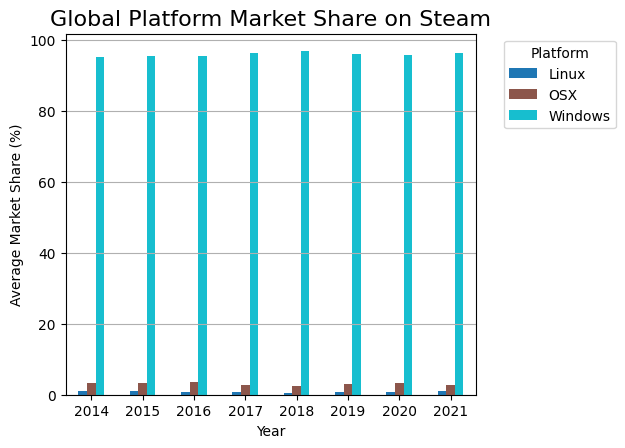

In [ ]:


df_yearly = df_os_share.resample("Y").mean()

df_yearly.index = df_yearly.index.year 
ax = df_yearly.plot(
    kind="bar",
    stacked=False,
    colormap="tab10"
)



plt.title("Global Platform Market Share on Steam", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Average Market Share (%)")
plt.legend(title="Platform", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [5]:
df_yearly

index,Linux,OSX,Windows
date,,,
2014-12-31,1.136364,3.408182,95.279091
2015-12-31,0.975000,3.321667,95.600833
2016-12-31,0.879167,3.496667,95.509167
2017-12-31,0.664167,2.802500,96.447500
2018-12-31,0.525000,2.471667,96.953333
2019-12-31,0.808333,3.090000,96.100000
2020-12-31,0.870000,3.400000,95.730000
2021-12-31,0.942500,2.785833,96.272500


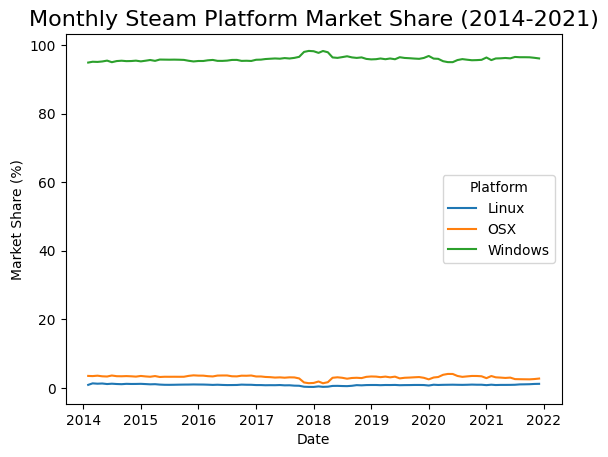

In [28]:


for platform in df_os_share.columns:
    plt.plot(df_os_share.index, df_os_share[platform], label=platform)

plt.title('Monthly Steam Platform Market Share (2014-2021)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.legend(title='Platform')
plt.show()


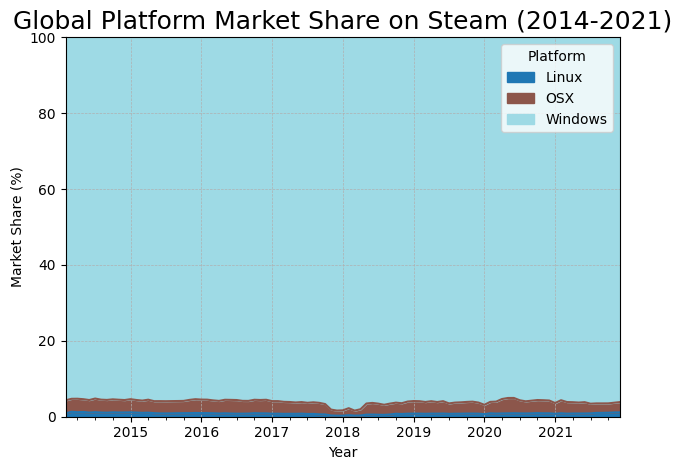

In [14]:
df_os_share.plot.area(
    colormap="tab20",
)

plt.title("Global Platform Market Share on Steam (2014-2021)", fontsize=18)
plt.xlabel("Year")
plt.ylabel("Market Share (%)")
plt.ylim(0, 100)
plt.legend(title="Platform")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


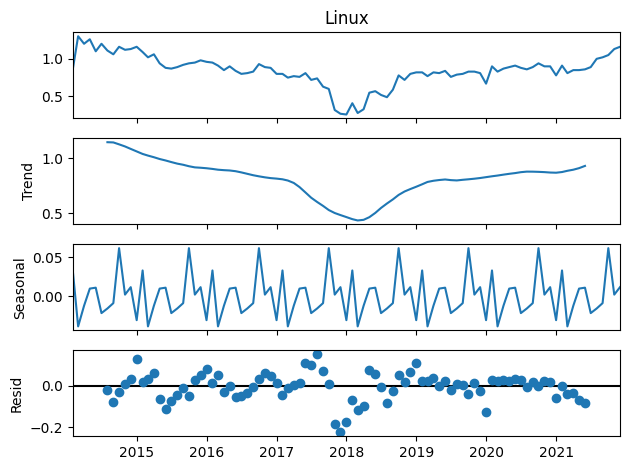

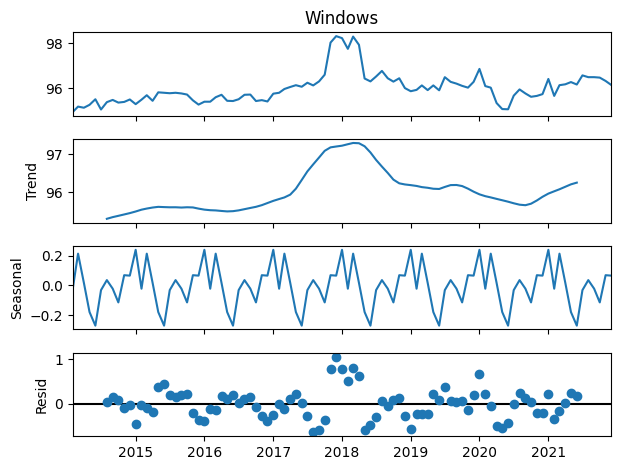

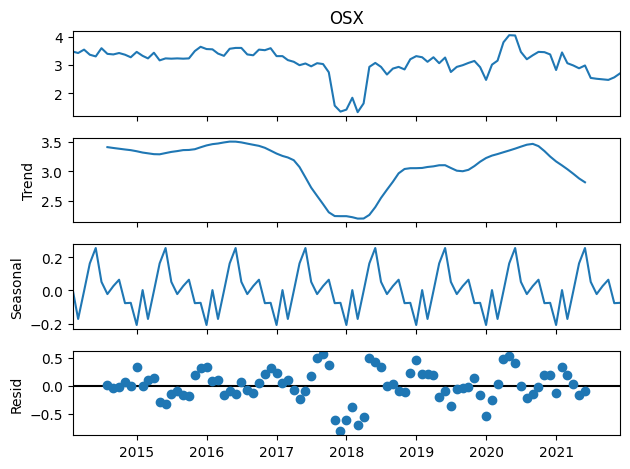

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = df_os_share["Linux"] 

decomposition = seasonal_decompose(ts, model='additive', period=12)
decomposition.plot()
plt.show()

ts = df_os_share["Windows"] 

decomposition = seasonal_decompose(ts, model='additive', period=12)
decomposition.plot()
plt.show()

ts = df_os_share["OSX"] 

decomposition = seasonal_decompose(ts, model='additive', period=12)
decomposition.plot()
plt.show()



This plot from statsmodels is a very good indicator that the data is seasonal, which calls for an autoregression model that is suited to interpret seasonal data. 

After filtering for OS share data, then pivoting to get 1 column per OS, we can now prep for the model. I believe SARIMA, or Seasonal AutoRegressive Integrated Moving Average, will be the optimal model to use in this context because of its ability to work with seasonal time-series data.